<!--announcements-->
<center>
    <img src="network.png" width="400px" /></a>
</center>

<h2>Introduction</h2>

In this project, you will implement a some neural networks to solve regression and image classification problems. This project will introduce you to some of the basics of implementing and training these powerful models. For this, we will be exploring more into the deep end with Course staffs' favorite ML framework: PyTorch!

For full documentation and details, here is their site https://pytorch.org/. PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab. Pytorch is very neat because, as you have seen your assignments, in order to do gradient descent we've had to calculate gradient manually. No more! Pytorch performs automatic differentation, as long as we use their functions in our code.

From this project, we will be implementing two neural network models learned in class:
* Multi-Layer Perceptrons
* Convolutional Neural Networks

We will also implement a __training loop__ and __testing loop__ in PyTorch for a handwriting classification task, MNIST.

Note: Because we are working with Pytorch functions and Modules, we will be using excusively Pytorch tensors instead of numpy arrays. Let's begin by importing some of the necessary functions.

In [132]:
%matplotlib notebook

#<GRADED>
import numpy as np
from numpy.matlib import repmat
import sys
import time
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets

from scipy.stats import linregress

# new torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# new vision-dataset-related torch imports
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

# misc imports
import random
#</GRADED>

<h2>Regression on Non-linear Functions</h2>

Recall from Project 6, where you were tasked to use gradient descent to find the parameters of a simple linear regression problem. We will re-visit the regression problem, but this time for _nonlinear_ data!

Before, we were able to model a simple linear function. Let's see if we can move onto a more complex function. Let's begin by generating some data for the sine function, $y=\sin (x).$

In [133]:
def gen_nonlinear_data(num_samples=10000):
    # generate random x samples for training and test sets
    xTr = torch.rand(num_samples, 1) * 2 * np.pi
    xTe = torch.rand(int(num_samples * 0.1), 1) * 2 * np.pi
    
    # gaussian noise for non-linear regression
    noise = torch.rand(num_samples, 1) * 0.2
    test_noise = torch.rand(int(num_samples * 0.1), 1) * 0.2
    
    # add noise on the labels for the training set
    yTr = torch.sin(xTr) + noise
    yTe = torch.sin(xTe) + test_noise
    return xTr, xTe, yTr, yTe

In [134]:
nl_xTr, nl_xTe, nl_yTr, nl_yTe = gen_nonlinear_data(num_samples=500)

Recall the <code>LinearRegressionModel</code> implemented in Project 6. We have copied it below (no need to re-implement it). As a reminder, PyTorch models inherit the class torch.nn.module, and you feed in a batch of $n$ samples as input and you get batch of outputs. Every torch module will implement two functions. __init__ as its constructor, and __forward__ function, which defines what happens when you call the module.

For the regression task, we use our familiar mean-squared error loss.

In [135]:
class LinearRegressionModel(nn.Module):
    def __init__(self, ndims):
        super(LinearRegressionModel, self).__init__()
        """ pytorch optimizer checks for the properties of the model, and if
            the torch.nn.Parameter requires gradient, then the model will update
            the parameters automatically.
        """
        self.w = nn.Parameter(torch.randn(ndims, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)
    
    def forward(self, x):
        return x @ self.w + self.b
    
def mse_loss(y_pred, y_true):
    square_diff = torch.pow((y_pred-y_true), 2)
    mean_error = 0.5 * torch.mean(square_diff)
    return mean_error

Here is a regression training loop in Pytorch, similar to the one from Project 6. We have supplied comments per line to help walk you through what each different part does.

In [136]:
def train_regression_model(xTr, yTr, model, num_epochs, lr=1e-2, print_freq=100, display_loss=True):
    """Train loop for a neural network model. Please use the Adam optimizer, optim.Adam.
    
    Input:
        xTr:     n x d matrix of regression input data
        yTr:     n-dimensional vector of regression labels
        model:   nn.Model to be trained
        num_epochs: number of epochs to train the model for
        lr:      learning rate for the optimizer
        print_freq: frequency to display the loss
        display_loss: boolean, if we print the loss
    
    Output:
        model:   nn.Module trained model
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)  # create an Adam optimizer for the model parameters
    
    for epoch in range(num_epochs):
        # need to zero the gradients in the optimizer so we don't
        # use the gradients from previous iterations
        optimizer.zero_grad()  
        pred = model(xTr)  # run the forward pass through the model to compute predictions
        loss = mse_loss(pred, yTr)
        loss.backward()  # compute the gradient wrt loss
        optimizer.step()  # performs a step of gradient descent
        if display_loss and (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))
    
    return model  # return trained model

Let's begin by seeing what happens when we run our linear model, <code>LinearRegressionModel</code>, on this data. Run the train loop as before on this new data, and plot the results. Visualize how good of a fit our line is to the data.

epoch 500 loss 0.117153100669384
epoch 1000 loss 0.09789058566093445
epoch 1500 loss 0.09672877192497253
epoch 2000 loss 0.09671330451965332
avg test error 0.10775701701641083


<IPython.core.display.Javascript object>


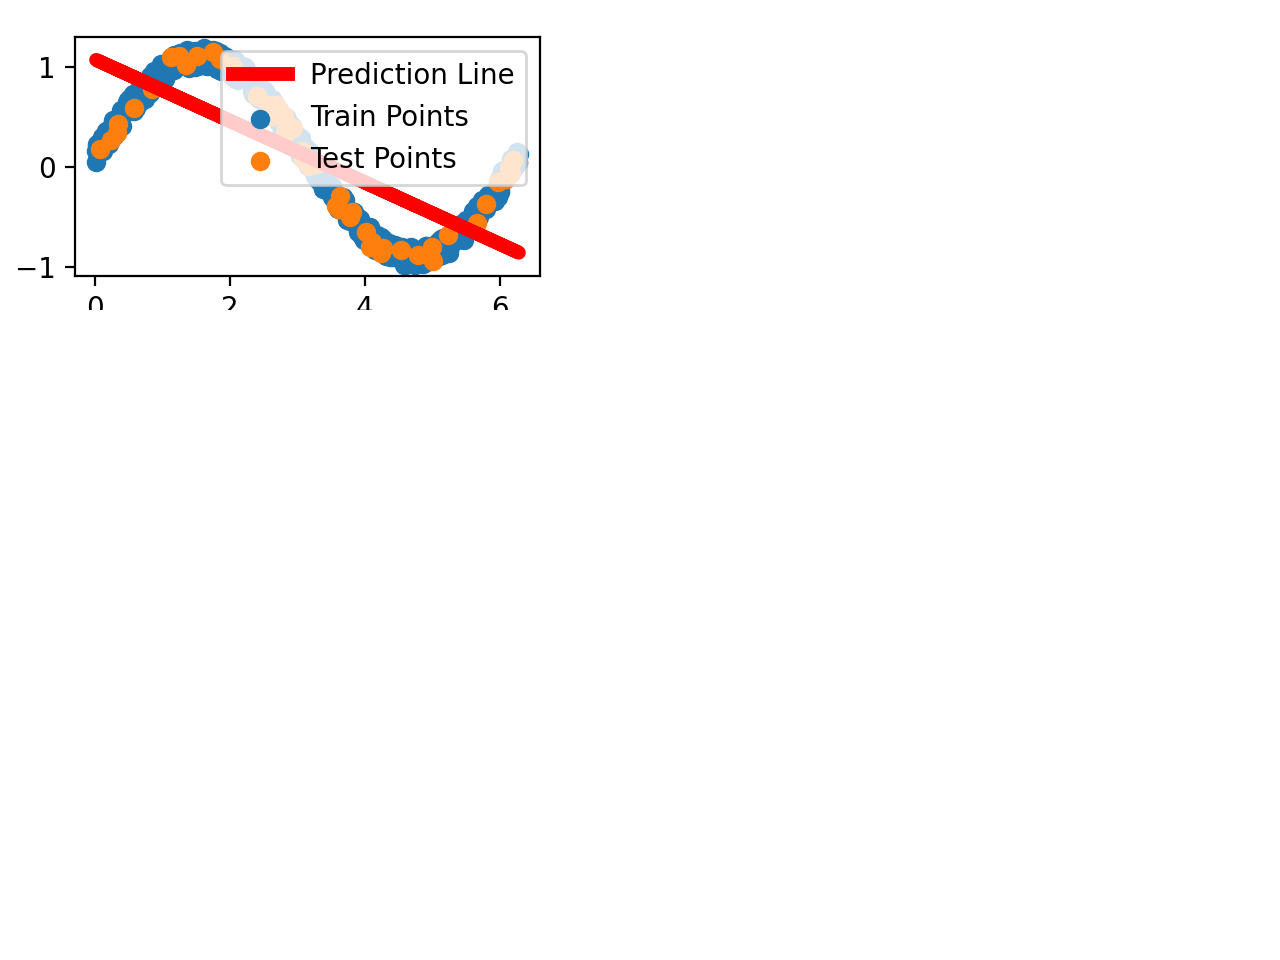

In [137]:
ndims = nl_xTr.shape[1]
linear_model = LinearRegressionModel(ndims)  # initialize the model
linear_model = train_regression_model(nl_xTr, nl_yTr,
                                      linear_model, 
                                      num_epochs=2000, 
                                      lr=1e-2, 
                                      print_freq=500)
avg_test_error = mse_loss(linear_model(nl_xTe), nl_yTe)  # compute the average test error
print('avg test error', avg_test_error.item())

# Visualize the results
plt.figure()
plt.plot(nl_xTr, linear_model(nl_xTr).detach(),linewidth=5.0, color="red", label="Prediction Line")
plt.scatter(nl_xTr, nl_yTr, label="Train Points")
plt.scatter(nl_xTe, nl_yTe, label="Test Points")
plt.legend()
plt.show()

Needless to say, a linear model doesn't model a sine function very well! Let's instead use our first neural network, a __Multi-Layer Perceptron model__. 

We need to define a few layers of the <code>MLPNet</code> using Pytorch, and implement the forward pass. For this network, write an MLP that has:
* Two fully connected layers: Use the Pytorch implementation, <code>nn.Linear(in_dim, out_dim)</code>. This will be updated automatically by Pytorch in our training loop.
* ReLU nonlinearities: Use the Pytorch implementation, <code>nn.functional.relu</code> between each of the linear layers.

In [150]:
# Create a Pytorch Multilayer Perceptron (MLP) Model
#<GRADED>
class MLPNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(MLPNet, self).__init__()
        """ pytorch optimizer checks for the properties of the model, and if
            the torch.nn.Parameter requires gradient, then the model will update
            the parameters automatically.
        """
        self.input_dim = input_dim
        
        # Initialize the fully connected layers
#         raise NotImplementedError("Your code goes here!")
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
            
    
    def forward(self, x):
        # Implement the forward pass, with ReLU non-linearities
#         raise NotImplementedError("Your code goes here!")
#         print(type(x @ self.fc1))
#         x = torch.flatten(x)
        relu = nn.functional.relu
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        
        return x
#</GRADED>

How does the __hidden dimensions__ in an MLP affect the output results? Try out various hidden dimensions using the code provided. We highly recommend for you to play with different number of hidden nodes using the slider tool. Do more or less hidden nodes result in smoother regression outputs? What is the tradeoff?

<IPython.core.display.Javascript object>


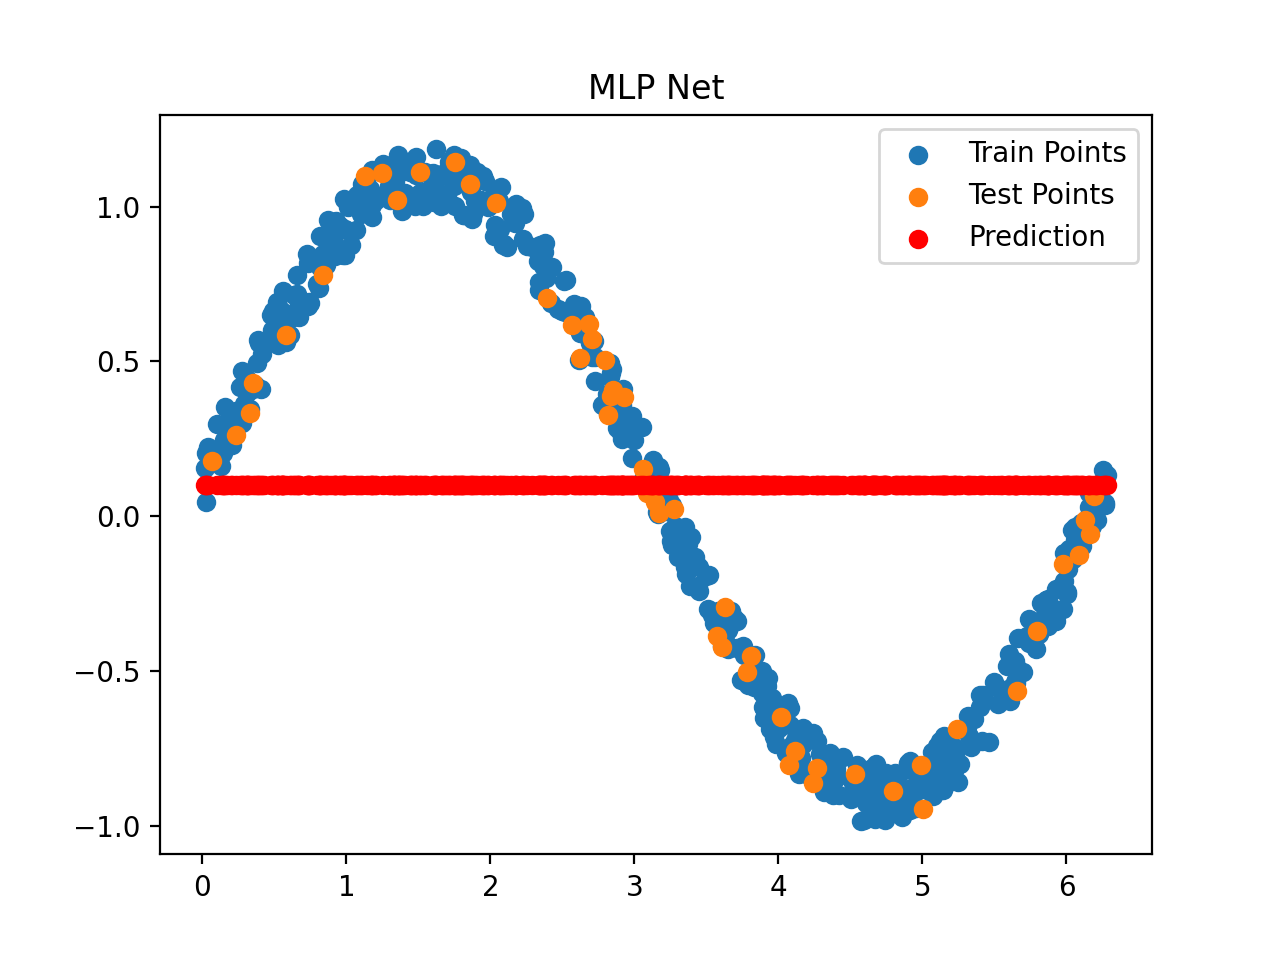

interactive(children=(IntSlider(value=1, description='hdims', min=1), Output()), _dom_classes=('widget-interac…

In [139]:
num_epochs = 2000
lr = 1e-3
trained_models = {}

fig = plt.figure()

def update(hdims):
    fig.clear()
    key = str(hdims)
    if key in trained_models:
        mlp_model = trained_models[key]
    else:
        mlp_model = MLPNet(input_dim=1, hidden_dim=hdims, output_dim=1)
        mlp_model = train_regression_model(nl_xTr, nl_yTr, mlp_model, num_epochs=num_epochs, lr=lr, display_loss=False)
        trained_models[key] = mlp_model
    plt.scatter(nl_xTr, nl_yTr, label="Train Points")
    plt.scatter(nl_xTe, nl_yTe, label="Test Points")
    plt.title('MLP Net')
    plt.scatter(nl_xTr, mlp_model(nl_xTr).detach(), color="red", marker='o', label="Prediction")
    plt.legend()
    fig.canvas.draw()

widgets.interact(update, hdims=widgets.IntSlider(value=1, min=1, max=100, step=1));

Run the regression train loop, <code>train_regression_model</code>, with the MLP model on the non-linear data. Use your favorite hidden dimension <code>hdim</code> from above to get the test error below 0.002. Additionally, what learning rates and number of epochs converges for the MLP model? To start, we suggest using <code>num_epochs = 5000</code>, and <code>lr = 1e-3</code>.

In [140]:
hdims = 100
num_epochs = 5000
lr = 1e-3

mlp_model = MLPNet(input_dim=1, hidden_dim=hdims, output_dim=1)
mlp_model = train_regression_model(nl_xTr, nl_yTr, mlp_model, num_epochs=num_epochs, lr=lr)
avg_test_error = mse_loss(mlp_model(nl_xTe), nl_yTe)
print('avg test error', avg_test_error.item())

epoch 100 loss 0.06581421196460724
epoch 200 loss 0.053515609353780746
epoch 300 loss 0.03871358558535576
epoch 400 loss 0.0272633358836174
epoch 500 loss 0.018540138378739357
epoch 600 loss 0.012367486022412777
epoch 700 loss 0.00834072008728981
epoch 800 loss 0.005821795202791691
epoch 900 loss 0.004270150791853666
epoch 1000 loss 0.003341636387631297
epoch 1100 loss 0.002757808193564415
epoch 1200 loss 0.0023886370472609997
epoch 1300 loss 0.0021579614840447903
epoch 1400 loss 0.0020016152411699295
epoch 1500 loss 0.0018912230152636766
epoch 1600 loss 0.0018129217205569148
epoch 1700 loss 0.001756375771947205
epoch 1800 loss 0.0017166221514344215
epoch 1900 loss 0.0016884789802134037
epoch 2000 loss 0.0016681409906595945
epoch 2100 loss 0.0016588318394497037
epoch 2200 loss 0.0016442013438791037
epoch 2300 loss 0.0016370263183489442
epoch 2400 loss 0.0016322125447914004
epoch 2500 loss 0.0016295115929096937
epoch 2600 loss 0.0016254049260169268
epoch 2700 loss 0.0016335162799805403


Now, we have trained our first neural network model! Let's predict by passing in input data via <code>mlp_model(x)</code>. 

Visualize how good of a fit our MLP is to the data, as compared to the linear model via a side-by-side comparison:

<IPython.core.display.Javascript object>


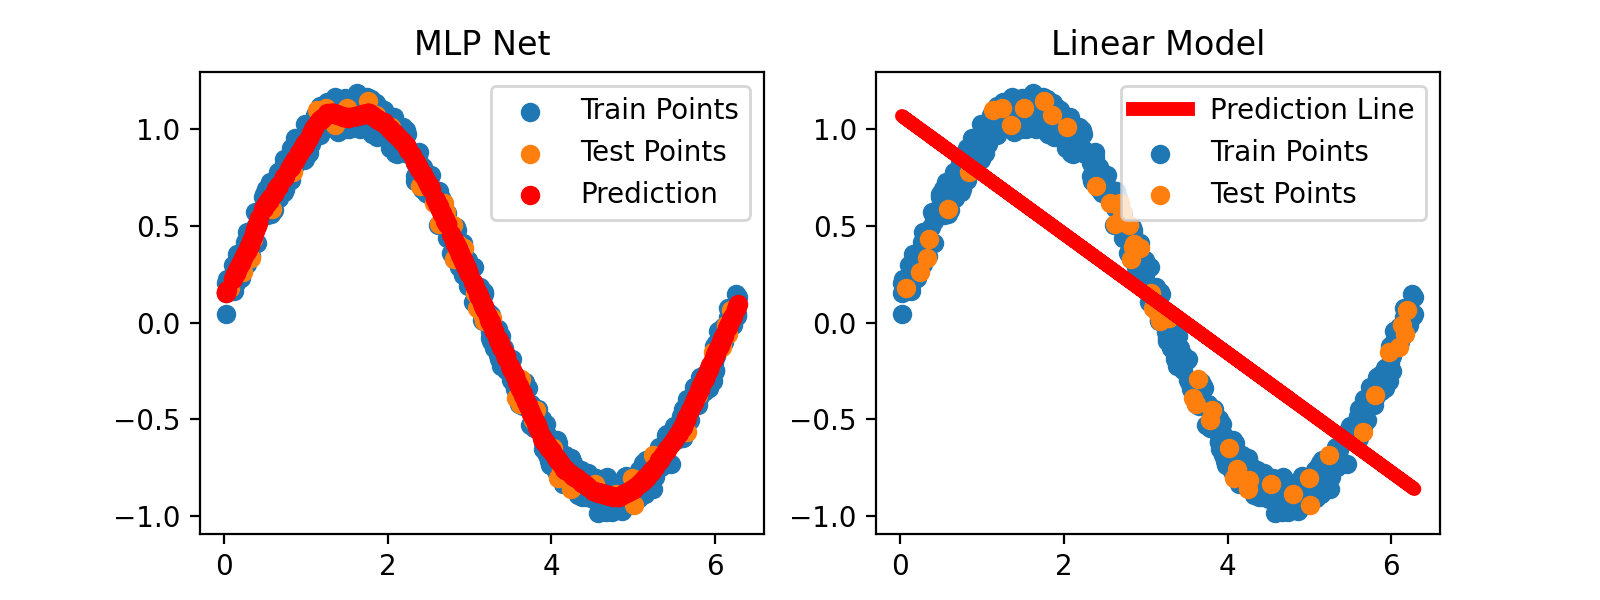

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))

# Plot the visualizations from our MLP Model
ax1.scatter(nl_xTr, nl_yTr, label="Train Points")
ax1.scatter(nl_xTe, nl_yTe, label="Test Points")
ax1.scatter(nl_xTr, mlp_model(nl_xTr).detach(), color="red", marker='o', label="Prediction")
ax1.legend()
ax1.set_title('MLP Net')

# Plot the visualizations from our MLP Model
ax2.scatter(nl_xTr, nl_yTr, label="Train Points")
ax2.scatter(nl_xTe, nl_yTe, label="Test Points")
ax2.plot(nl_xTr, linear_model(nl_xTr).detach(),linewidth=5.0, color="red", label="Prediction Line")
ax2.legend()
ax2.set_title('Linear Model')

plt.show()

<h2>Handwritten Digits Classification</h2>

One of the tasks neural network models can solve quite well is classification! We will explore their capabilities on a simple classification task, classifying handwritten digits. Specifically, we will be taking an image of a digit between 0 - 9 and classifying which digit it is.




<center>
    <img src="320px-MnistExamples.png" width="400px" /></a>
</center>

For this task, we will look into the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). The MNIST database consists of black and white handwritten digits, cropped to a fixed size. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

Fortunately for us, Pytorch provides an easy implementation to download the cleaned and already prepared data, using a few lines of code. Let us load it and visualize some of the images.

In [142]:
# Load the dataset
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root=".", train=True, transform=trans, download=True)
train_subset_indices = np.load("train_subset_indices.npy")  # load a predefined subset for efficiency
train_set = torch.utils.data.Subset(train_set, train_subset_indices)
test_set = dset.MNIST(root=".", train=False, transform=trans, download=True)

batch_size = 64

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

<IPython.core.display.Javascript object>


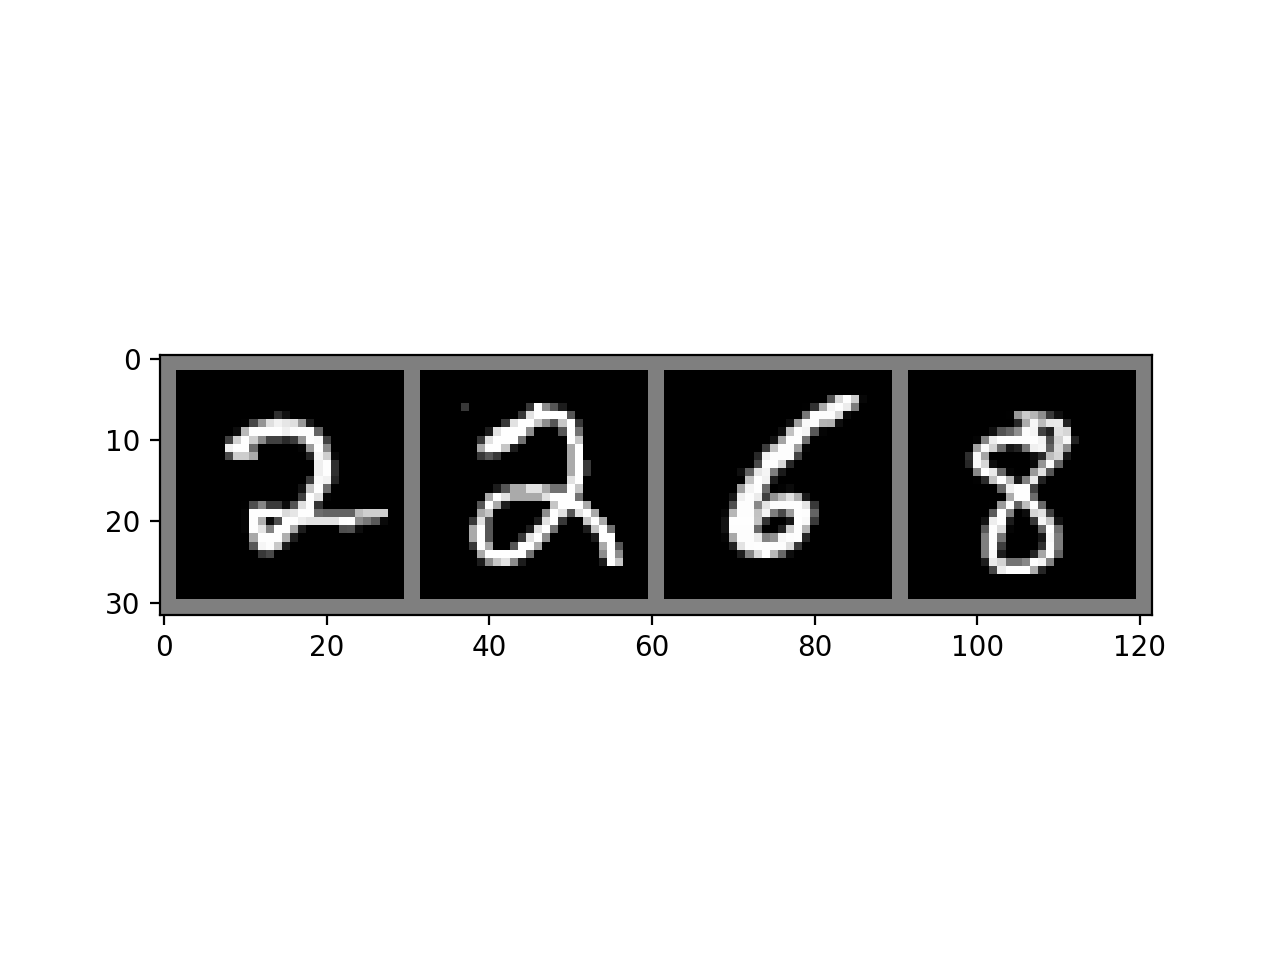

labels are: 2 2 6 8


In [143]:
def imshow(img):
    img = img + 0.5     # unnormalize
    plt.figure()
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

num_show_img = 4
# show images
imshow(torchvision.utils.make_grid(images[:num_show_img]))
# print labels
print('labels are:', ' '.join('%d' % labels[j] for j in range(num_show_img)))

Update the regression train loop (given above in <code>train_regression_model</code>) to train a classification model instead. The key difference is the loss function used is _no longer the MSE loss_. 

We will instead use the cross entropy loss, which is implemented for us in Pytorch, <code>nn.functional.cross_entropy(predictions, labels)</code>. Implement the new training loop, <code>train_classification_model</code>, and assume that the prediction outputs from the model are in one-hot format. 

In [144]:
# Training function
#<GRADED>
def train_classification_model(train_loader, model, num_epochs, lr=1e-1, print_freq=100):
    """Train loop for a neural network model. Please use the SGD optimizer, optim.SGD.
    
    Input:
        train_loader:    Data loader for the train set. 
                         Enumerate through to train with each batch.
        model:           nn.Model to be trained
        num_epochs:      number of epochs to train the model for
        lr:              learning rate for the optimizer
        print_freq:      frequency to display the loss
    
    Output:
        model:   nn.Module trained model
    """
    optimizer = optim.SGD(model.parameters(), lr=lr)  # create an SGD optimizer for the model parameters
    for epoch in range(num_epochs):

        # Iterate through the dataloader for each epoch
        for batch_idx, (imgs, labels) in enumerate(train_loader):
            # imgs (torch.Tensor):    batch of input images
            # labels (torch.Tensor):  batch labels corresponding to the inputs
            
            # Implement the training loop using imgs, labels, and cross entropy loss
#             raise NotImplementedError("Your code goes here!")
            imgs = torch.reshape(imgs, [labels.shape[0], 784])
            
            optimizer.zero_grad()
            #print(imgs.shape)
            pred = model(imgs)
            loss = nn.functional.cross_entropy(pred, labels)
            loss.backward()
            optimizer.step()
#             print('\tbatch {} loss {}'.format(batch_idx+1, loss.item()))
        #if (epoch + 1) % print_freq == 0:
        print('epoch {} loss {}'.format(epoch+1, loss.item()))
            
            
            
            
            
    return model  # return trained model
#</GRADED>

Additionally, implement the classification test function. Compute the accuracy of our model over the test set. We say that the predicted label is the digit that the model outputs the _maximum score_, and a correct prediction is one where the maximum score matches the true label. Return the average accuracy over all batches in the test set.

In [3]:
# Test function
#<GRADED>
def test_classification_model(test_loader, model):
    """Tests the accuracy of the model.
    
    Input:
        test_loader:      Data loader for the test set. 
                          Enumerate through to test each example.
        model:            nn.Module model being evaluate.
        
    Output:
        accuracy:         Accuracy of the model on the test set.
    """
    # Compute the model accuracy
    
    accuracy = 0
    num_correct = 0
    num_total = 0
    
    for batch_idx, (imgs, labels) in enumerate(test_loader):
        #raise NotImplementedError("Your code goes here!")
        imgs = torch.reshape(imgs, (-1, 784))
        preds = model(imgs)
        for i in range(len(preds)):
            num_total += 1
            pred = torch.argmax(preds[i])
            num_correct += 1 if pred == labels[i] else 0
    
    accuracy = num_correct / num_total
        
    return accuracy
#</GRADED>

Finally, we are ready to train an MLP neural network on this classification task! Initialize a <code>MLPNet</code> with the proper input dimension and output dimension. Play around with the hidden dimension to get the accuracy above 95\%. Additionally, what learning rates and number of epochs converges for the MLP model? To start, we suggest using <code>num_epochs = 40</code> and <code>lr = 1e-2</code>.

In [146]:
# Train an MLP model on MNSIT
hidden_dim = 40
num_epochs = 40
lr = 1e-2

mlp_model = MLPNet(input_dim=28*28, hidden_dim=hidden_dim, output_dim=10)
print('the number of parameters', sum(parameter.view(-1).size()[0] for parameter in mlp_model.parameters()))
mlp_model = train_classification_model(train_loader, mlp_model, num_epochs=num_epochs, lr=lr)
avg_test_acc = test_classification_model(test_loader, mlp_model)
print('avg test accuracy', avg_test_acc)

the number of parameters 805
epoch 1 loss 2.1444990634918213
avg test accuracy 0.17207404458598727


<h3>Convolutional Neural Networks</h3>

In class, we learned about about Convolutional Neural Networks (or CNN for short) that is explicity designed for image inputs. Let's implement and train a CNN on the MNIST dataset!

We need to define a few layers of the <code>ConvNet</code> using Pytorch, and implement the forward pass. For this network, write an CNN that has:
* Two convolutional layers: Use the Pytorch implementation, <code>nn.Conv2d(in_channels, out_channels)</code>. For each convolutional layer, set <code>kernel_size=3</code>, <code>stride=1</code>, <code>padding=1</code> and <code>bias=False</code>.
* ReLU nonlinearities: Use the Pytorch implementation, <code>nn.functional.relu</code> between each of the layers.
* Max-Pooling layers: Use the Pytorch implementation, <code>nn.functional.max_pool2d</code> to pool after each of the ReLU. For each max-pooling layer, set <code>kernel_size=2</code>, <code>stride=2</code>.
* Last layer a fully connected layer: Use the Pytorch implementation, <code>nn.Linear(in_dim, out_dim)</code>. <code>in_dim</code> depends on the size of input image (MNIST images), which is <code>28 * 28</code> in our case. Make sure to re-shape the input into a batch of vectors to pass it through the last layer using the function: <code>Tensor.view(*shape)</code>.

In [147]:
# Create Pytorch ConvNet Model
#<GRADED>
class ConvNet(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=32, output_dim=1):
        super(ConvNet, self).__init__()
        
        # Initialize the ConvNet layers
        #raise NotImplementedError("Your code goes here!")
        self.conv1 = nn.Conv2d(input_channels, hidden_channels, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.fc = nn.Linear(hidden_channels*49, output_dim)
        
        
    def forward(self, x):
        # Implement the forward pass, with ReLU non-linearities and max-pooling
        #raise NotImplementedError("Your code goes here!")
        n = x.shape[0]
        x = torch.reshape(x, (n,1,28,28))
        relu = nn.functional.relu
        max_pool = lambda input_ : nn.functional.max_pool2d(input_, kernel_size=2, stride=2)
#         print('{} before conv1'.format(x.shape))
        x = self.conv1(x)
#         print('{} after conv1 before maxpool+relu'.format(x.shape))
        x = max_pool(relu(x))
#         print('{} after maxpool+relu before conv2'.format(x.shape))
        x = self.conv2(x)
#         print('{} after conv2 before maxpool+relu'.format(x.shape))
        x = max_pool(relu(x))
#         print('{} after maxpool+relu before fc'.format(x.shape))
        x = torch.reshape(x, (n, -1))
        x = self.fc(x)
              
        return x
#</GRADED>

Run the classificiation train loop, this time with the <code>ConvNet</code> implemented above. Try out different hidden channel dimension to obtain an accuracy above 95\%. (Hint: the channel dimension should not be above 50 for computational efficiency.)

Once again, what learning rates and number of epochs converges for the CNN model? To start, we suggest using <code>num_epochs = 40</code> and <code>lr = 1e-3</code>.

In [148]:
# Train a convnet model on MNIST
hidden_channels = 40
num_epochs = 60
lr = 1e-3

conv_model = ConvNet(input_channels=1, hidden_channels=hidden_channels, output_dim=10)
print('the number of parameters:', sum(parameter.view(-1).size()[0] for parameter in conv_model.parameters()))
conv_model = train_classification_model(train_loader, conv_model, num_epochs=num_epochs, lr=lr)
avg_test_acc = test_classification_model(test_loader, conv_model)
print('avg test accuracy', avg_test_acc)

the number of parameters: 34370
epoch 1 loss 2.297197103500366
epoch 2 loss 2.2883923053741455
epoch 3 loss 2.2745513916015625
epoch 4 loss 2.243746519088745
epoch 5 loss 2.255654811859131
epoch 6 loss 2.2203333377838135
epoch 7 loss 2.179553508758545
epoch 8 loss 2.1829826831817627
epoch 9 loss 2.1122095584869385
epoch 10 loss 2.1237220764160156
epoch 11 loss 2.0595223903656006
epoch 12 loss 1.9951725006103516
epoch 13 loss 1.9066104888916016
epoch 14 loss 1.822138786315918
epoch 15 loss 1.6463820934295654
epoch 16 loss 1.5283938646316528
epoch 17 loss 1.6100521087646484
epoch 18 loss 1.1986703872680664
epoch 19 loss 1.348376989364624
epoch 20 loss 1.1010456085205078
epoch 21 loss 0.9913961887359619
epoch 22 loss 0.9272569417953491
epoch 23 loss 0.7551607489585876
epoch 24 loss 0.6030300259590149
epoch 25 loss 0.7832190990447998
epoch 26 loss 0.389899879693985
epoch 27 loss 0.6431796550750732
epoch 28 loss 0.46642357110977173
epoch 29 loss 0.367805540561676
epoch 30 loss 0.31399112939

In [151]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print(images.shape)

# Make a forward pass to get predictions of the MLP model
mlp_scores = mlp_model(images)
_, mlp_preds = torch.max(mlp_scores.data, 1)

# Make a forward pass to get predictions of the ConvNet model
conv_scores = conv_model(images)
_, conv_preds = torch.max(conv_scores.data, 1)

show_img_idx = np.random.randint(images.shape[0], size=7)
# show images
imshow(torchvision.utils.make_grid(images[show_img_idx]))
# print labels
print('labels are:', ' '.join('%d' % labels[j] for j in show_img_idx))
# print predictions
print('MLP predictions are:', ' '.join('%d' % mlp_preds[j] for j in show_img_idx))
print('CNN predictions are:', ' '.join('%d' % conv_preds[j] for j in show_img_idx))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1792x28 and 784x1)

<h3>Why Do CNN's Work?</h3>

Let's try to build some intuition behind why Convolution Neural Networks work well for image inputs.

For a toy experiment, let's shuffle the pixels for each of the input images, _but only in a set order_. Would we expect to see ConvNet's still working better than MLP?

In [ ]:
# Load the shuffled dataset
torch.manual_seed(0)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
pixel_shuffle_train_set = dset.MNIST(root=".", train=True, transform=trans, download=True)
train_subset_indices = np.load("train_subset_indices.npy")  # load a subset for efficiency
pixel_shuffle_train_set = torch.utils.data.Subset(pixel_shuffle_train_set, train_subset_indices)
pixel_shuffle_test_set = dset.MNIST(root=".", train=False, transform=trans, download=True)

randperm = torch.randperm(28 * 28)
pixel_shuffle_train_set.dataset.data = pixel_shuffle_train_set.dataset.data.view(-1, 28 * 28)[:, randperm].view(-1, 28, 28)
pixel_shuffle_test_set.data = pixel_shuffle_test_set.data.view(-1, 28 * 28)[:, randperm].view(-1, 28, 28)

batch_size = 64
pixel_shuffle_train_loader = torch.utils.data.DataLoader(
                 dataset=pixel_shuffle_train_set,
                 batch_size=batch_size,
                 shuffle=True)
pixel_shuffle_test_loader = torch.utils.data.DataLoader(
                dataset=pixel_shuffle_test_set,
                batch_size=batch_size,
                shuffle=False)

In [ ]:
dataiter = iter(pixel_shuffle_train_loader)
images, labels = dataiter.next()

num_show_img = 4
# show shuffled images
imshow(torchvision.utils.make_grid(images[:num_show_img]))
# print labels
print('labels are:', ' '.join('%d' % labels[j] for j in range(num_show_img)))

It looks like kind of a mess! But let's train an MLP model anyways, as before, and observe the new test accuracy on this shuffled-pixel dataset. __Use the same hyperparameters as you did before__.

In [130]:
# Train an MLP model on pixel-shuffled MNSIT
hidden_dim = None
num_epochs = None
lr = None

mlp_model = MLPNet(input_dim=28*28, hidden_dim=hidden_dim, output_dim=10)
print('the number of parameters:', sum(parameter.view(-1).size()[0] for parameter in mlp_model.parameters()))
mlp_model = train_classification_model(pixel_shuffle_train_loader, mlp_model, num_epochs=num_epochs, lr=lr)
avg_test_acc = test_classification_model(pixel_shuffle_test_loader, mlp_model)
print('avg test accuracy', avg_test_acc)

TypeError: new() received an invalid combination of arguments - got (NoneType, int), but expected one of:
 * (*, torch.device device)
      didn't match because some of the arguments have invalid types: (!NoneType!, !int!)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


Additionally, train a CNN model, as before, and observe the new test accuracy on this shuffled-pixel dataset. __Use the same hyperparameters as you did before__.

In [ ]:
# Train a ConvNet model on pixel-shuffled MNSIT
hidden_channels = None
num_epochs = None
lr = None

conv_model = ConvNet(input_channels=1, hidden_channels=hidden_channels, output_dim=10)
print('the number of parameters:', sum(parameter.view(-1).size()[0] for parameter in conv_model.parameters()))
conv_model = train_classification_model(pixel_shuffle_train_loader, conv_model, num_epochs=num_epochs, lr=lr)
avg_test_acc = test_classification_model(pixel_shuffle_test_loader, conv_model)
print('avg test accuracy', avg_test_acc)

Observe that the accuracy is now _slightly lower than_ that of MLP models! This shows that CNN's utilize the stucture of the image (i.e., pixel proximity) to make their predictions. With the pixel orders shuffled, it is no longer as good of a model.

Let us visualize some of the prediction results.

In [ ]:
dataiter = iter(pixel_shuffle_test_loader)
images, labels = dataiter.next()

# Make a forward pass to get predictions of the MLP model
mlp_scores = mlp_model(images)
_, mlp_preds = torch.max(mlp_scores.data, 1)

# Make a forward pass to get predictions of the ConvNet model
conv_scores = conv_model(images)
_, conv_preds = torch.max(conv_scores.data, 1)

show_img_idx = np.random.randint(images.shape[0], size=7)
# show images
imshow(torchvision.utils.make_grid(images[show_img_idx]))
# print labels
print('labels are:', ' '.join('%d' % labels[j] for j in show_img_idx))
# print predictions
print('MLP predictions are:', ' '.join('%d' % mlp_preds[j] for j in show_img_idx))
print('CNN predictions are:', ' '.join('%d' % conv_preds[j] for j in show_img_idx))